In [1]:
import mph
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import os
import math
import sys
import gpytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.quasirandom import SobolEngine
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints.constraints import Interval
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP

C:\Users\qoqud\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def save_array_numpy(array, base_filename, folder_path='.'):
    if not folder_path.endswith('/'):
        folder_path += '/'
    
    filename = base_filename + '.txt'
    unique_name = filename
    counter = 1
    while os.path.exists(folder_path + unique_name):
        unique_name = f"{base_filename}_{counter}.txt"
        counter += 1
    np.savetxt(folder_path + unique_name, array, delimiter=',')
    print(f"Array saved to {folder_path + unique_name}")
    
def average_amplitude_for_multiple_points(grid_data, Real_data, points, n):
    avg_amplitudes = []
    for point in points:
        sum_amplitudes = np.zeros((len(Real_data),))
        point_reshaped = np.reshape(point, (1, 2))
        count_within_distance = np.zeros((1), dtype=int)
        distances = np.sqrt((grid_data - point_reshaped) ** 2).sum(axis=-1)

        within_distance_indices = np.where(distances < n)[1]

        count_within_distance = len(within_distance_indices)
        if within_distance_indices.size > 0:
            sum_amplitudes[:] = Real_data[:, within_distance_indices, 2].max(axis=-1)
        
            avg_amplitude = sum_amplitudes / 1
        else:
            avg_amplitude = np.zeros((len(Real_data),))

        avg_amplitudes.append(avg_amplitude)
    
    return avg_amplitudes

def generate_coordinates(x, y, n, array=np.array([])):
    x1, y1 = x
    x2, y2 = y
    x_step = (x2 - x1) / (n + 1)
    y_step = (y2 - y1) / (n + 1)
    
    if len(array) == 0:
        array = np.array([x1, y1])

    for i in range(1, n + 1):
        x = x1 + i * x_step
        y = y1 + i * y_step
        array = np.append(array,[x, y])
    array = np.append(array,[x2, y2])
    
    return array.reshape(-1,2)

def distance(x,y):
    x1, y1 = x
    x2, y2 = y
    distance = pow(pow((x1-x2),2)+pow((y1-y2),2),0.5)
    return distance

def iteration_array_gen(array, spacing, output):
    for i in range(array.shape[0]-1):
        num = int(distance(array[i,:],array[i+1,:])/spacing)
        output = generate_coordinates(array[i,:],array[i+1,:],num, output)
    return output

In [3]:
def data_sorting(data, label, K, scaler_x = 'null', scaler_y = 'null', scaler_c = 'null', scaler_t = 'null'):
    num,row,col = data.shape
    _,col_l = label.shape
    num_set_trim = data.reshape(-1,11,row,col)
    label_trim = label.reshape(-1,11,col_l)
    num_set_trimmed = num_set_trim[:,K:11,:,:].reshape(-1,row,col)
    label_trimmed = label_trim[:,K:11,:].reshape(-1,col_l)
    if scaler_c == 'null':
        scaler_c = MinMaxScaler(feature_range=(-1,1)).fit(num_set_trimmed[:,:,2].reshape(-1,1))
    if scaler_x == 'null':
        scaler_x = MinMaxScaler(feature_range=(0,1)).fit(num_set_trimmed[:,:,0].reshape(-1,1))
    if scaler_y == 'null':
        scaler_y = MinMaxScaler(feature_range=(0,1)).fit(num_set_trimmed[:,:,1].reshape(-1,1))
    if scaler_t == 'null':
        scaler_t = MinMaxScaler(feature_range=(0,1)).fit(label_trimmed[:,2].reshape(-1,1))
        
    concent = scaler_c.transform(num_set_trimmed[:,:,2].reshape(-1,1))
    x = scaler_x.transform(num_set_trimmed[:,:,0].reshape(-1,1))
    label_x = scaler_x.transform(label_trimmed[:,0].reshape(-1,1))
    y = scaler_y.transform(num_set_trimmed[:,:,1].reshape(-1,1))
    label_y = scaler_y.transform(label_trimmed[:,1].reshape(-1,1))
    label_t = scaler_t.transform(label_trimmed[:,2].reshape(-1,1))
    Array = np.concatenate((x.reshape(-1,row,1),y.reshape(-1,row,1),concent.reshape(-1,row,1)),axis=-1)
    labels = np.concatenate((label_x.reshape(-1,1),label_y.reshape(-1,1),label_t.reshape(-1,1)),axis=-1)

    return Array, labels, scaler_x, scaler_y, scaler_c, scaler_t
    #test_predict = scaler.inverse_transform(test_predict_scaled)

In [4]:
def generate_random_points(grid_x, grid_y, num_points=5):
    return [(np.random.choice(grid_x), np.random.choice(grid_y)) for _ in range(num_points)]

def find_closest_grid_points(random_points, grid_data):
    closest_indices = []
    for x, y in random_points:
        distances = np.sqrt((grid_data[0, :, 0] - x)**2 + (grid_data[0, :, 1] - y)**2)
        closest_indices.append(np.argmin(distances, axis=0))
    return np.array(closest_indices)

def extract_sensor_data_old(grid_data, data, num_points=5, points=[]):
    num,row,col = data.shape
    grid_x = np.unique(grid_data[0, :, 0])
    grid_y = np.unique(grid_data[0, :, 1])
    random_points = np.array(points)
    if len(random_points) == 0:
        random_points = generate_random_points(grid_x, grid_y, num_points)
    closest_indices = find_closest_grid_points(random_points, grid_data)
    data_ = data.reshape(-1,9,row,col)
    sensor_data = np.zeros((int(num/9), num_points * 11))
    j= 0
    for i in range(num_points):
        sensor_data[:,i*11:i*11+2] = data_[:,0,closest_indices[i],:2].reshape(-1,2)
        sensor_data[:,i*11+2:(i+1)*11] = data_[:,:,closest_indices[i],2].reshape(-1,9)
    return sensor_data, random_points

def extract_sensor_data(grid_data, data, num_points=5, points=[],distance=3):
    num,row,col = data.shape
    grid_x = np.unique(grid_data[0, :, 0])
    grid_y = np.unique(grid_data[0, :, 1])
    random_points = np.array(points)
    if len(random_points) == 0:
        random_points = generate_random_points(grid_x, grid_y, num_points)
    closest_indices = find_closest_grid_points(random_points, grid_data)
    Average = average_amplitude_for_multiple_points(grid_data, data, points, distance)
    Average_data = np.array(Average)
    data_ = data.reshape(-1,9,row,col)
    sensor_data = np.zeros((int(num/9), num_points * 11))
    j= 0
    for i in range(num_points):
        sensor_data[:,i*11:i*11+2] = data_[:,0,closest_indices[i],:2].reshape(-1,2)
        sensor_data[:,i*11+2:(i+1)*11] = Average_data[i,:].reshape(-1,9)
    return sensor_data, random_points

In [5]:
class GasLeakDetectorNN(nn.Module):
    def __init__(self, num_sensors=5):
        super(GasLeakDetectorNN, self).__init__()
        self.num_sensors = num_sensors
        input_dim = num_sensors * 11
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 64)  
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        #x = F.relu(self.fc4(x))
        #x = F.relu(self.fc5(x))
        #x = self.fc4(x)
        return x

In [6]:
np_labels = np.load('./Datalabels.npy')
np_data = np.load('./Datasets.npy')
Array_X, Labels, sc_x, sc_y, sc_c, sc_t = data_sorting(np_data, np_labels, 2)
grid = np_data[0,:,:2].reshape(1,-1,2)
print(max(np_data[0,:,0]),min(np_data[0,:,0]),max(np_data[0,:,1]),min(np_data[0,:,1]))
radius = 4
Labels_trimmed = Labels.reshape(-1,9,3)[:,0,:2]

49.46751129823234 0.4675112982323418 22.44997892328108 0.44997892328107925


In [7]:
Array_X = Array_X.reshape(-1,9,4455,3)
indices = np.arange(Array_X.shape[0])
print(Array_X.shape, Labels_trimmed.shape)
np.random.shuffle(indices)
D1 = Array_X[indices]
D2 = Labels_trimmed[indices]
c11, _,_,_ = D1.shape
RoundC = round(c11*0.8)+1
RoundC2 = round(c11*1)+1
D_Train = D1[:RoundC, :]
D_Valid = D1[RoundC:RoundC2, :]
D_Train_L = D2[:RoundC, :]
D_Valid_L = D2[RoundC:RoundC2, :]
print(np_data.shape)

(1041, 9, 4455, 3) (1041, 2)
(11451, 4455, 3)


In [8]:
print(Labels[:,1].max())

0.9203555034872237


In [9]:
scalers = [sc_x, sc_y, sc_c, sc_t]

In [10]:
Sensor_coord = [25.7148,17.1982],[16.4658, 14.9485],[15,15], [20,13],[27.5,13.2] ,[20.6910,9.2276],[30.0131,14.0141],[45.2932,8.4008],[37,8],[39.5,15],[35,5],[18,10]

In [11]:
def objective_function(sensor_coordinates, grid_data, D_Train_, D_Valid_, D_Train_L, D_Valid_L, scaler, epochs=350, batch_size=64, scale = True):
    #sensor value extraction
    sensor_coordinates = np.array(sensor_coordinates)
    D_Train_E = D_Train_.reshape(-1,4455,3)
    D_Valid_E = D_Valid_.reshape(-1,4455,3)
    
    D_Train_w,_ = extract_sensor_data(grid_data, D_Train_E, len(sensor_coordinates), sensor_coordinates)
    D_Valid_w,_ = extract_sensor_data(grid_data, D_Valid_E, len(sensor_coordinates), sensor_coordinates)
    
    D_Train = np.concatenate((D_Train_w, D_Train_L), axis=-1)
    D_Valid = np.concatenate((D_Valid_w, D_Valid_L), axis=-1)
    # Convert to PyTorch tensors and DataLoader
    train_loader, valid_loader = prepare_data_loaders(D_Train, D_Valid, batch_size=batch_size)

    # Define and train the neural network
    model = GasLeakDetectorNN(num_sensors = len(sensor_coordinates))
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model = train_model(model, criterion, optimizer, train_loader, epochs=epochs)

    # Evaluate the model
    error = evaluate_model(model, criterion, valid_loader, scaler, scale)

    return error

def prepare_data_loaders(D_Train, D_Valid, batch_size=64):
    X_train = torch.tensor(D_Train[:, :-2], dtype=torch.float32)
    y_train = torch.tensor(D_Train[:, -2:], dtype=torch.float32)
    X_valid = torch.tensor(D_Valid[:, :-2], dtype=torch.float32)
    y_valid = torch.tensor(D_Valid[:, -2:], dtype=torch.float32)
    
    # Create DataLoader instances for batch processing
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    
    train_loader = DataLoader(train_dataset, batch_size, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)
    
    return train_loader, valid_loader

def train_model(model, criterion, optimizer, train_loader, epochs=50):  
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
        train_loss = train_loss/len(train_loader.dataset)
        
    return model

def evaluate_model(model, criterion, valid_loader, scaler, scale = True):
    sc_x, sc_y, _, sc_t = scaler
    model.eval()
    valid_loss = 0.0
    original_scale_mse = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)
            # Inverse transform the output and target to their original scale
            output_np = output.numpy()  # Convert to numpy array if not already
            target_np = target.numpy()
            
            # Inverse transform x coordinates
            output_x_inv = sc_x.inverse_transform(output_np[:, 0].reshape(-1, 1))
            target_x_inv = sc_x.inverse_transform(target_np[:, 0].reshape(-1, 1))
            
            # Inverse transform y coordinates
            output_y_inv = sc_y.inverse_transform(output_np[:, 1].reshape(-1, 1))
            target_y_inv = sc_y.inverse_transform(target_np[:, 1].reshape(-1, 1))
            
            #output_t_inv = sc_t.inverse_transform(output_np[:, 2].reshape(-1, 1))
            #target_t_inv = sc_t.inverse_transform(target_np[:, 2].reshape(-1, 1))
            
            # Concatenate the inversely transformed x and y coordinates
            #output_inv = np.concatenate((output_x_inv, output_y_inv, output_t_inv), axis=1)
            #target_inv = np.concatenate((target_x_inv, target_y_inv, target_t_inv), axis=1)
            output_inv = np.concatenate((output_x_inv, output_y_inv), axis=1)
            target_inv = np.concatenate((target_x_inv, target_y_inv), axis=1)
            
            # Calculate MSE on the original scale
            mse_original_scale = mean_squared_error(target_inv, output_inv)
            original_scale_mse += mse_original_scale * data.size(0)
            
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            
    valid_loss = valid_loss/len(valid_loader.dataset)
    original_scale_mse = original_scale_mse / len(valid_loader.dataset)
    #valid_losses.append(valid_loss)
    print(f'Validation MSE on Original Scale: {original_scale_mse:.4f}')
    
    return original_scale_mse if scale else valid_loss

In [12]:
final_sensor_positions = [31.49191176, 11.94716053, 47.4024575,  10.24149027, 25.30450364, 14.81949917,
 19.97105664,  1.81336741, 41.98124424, 16.89335784, 41.26390968,  6.98413684,
 46.96124783,  4.7709943,  27.36858491, 20.58585638, 22.67589839,  8.51132274,
 48.32623684, 15.74297626]
first_sensor_positions = [21.22340156,  1.89913663,  9.85779668, 10.74680648, 17.4866936,   1.73966265,
 21.98900012,  6.18795932, 15.14300318,  5.61182399, 27.85815953,  7.75394655,
 37.33265196, 10.37073339,  7.07493982,  2.65066583,  8.61302454, 13.63289673,
  4.90981664, 17.24208938, 16.79217428,  0.91508482,  1.92265781,  6.42452355]

#Sensor verify

In [13]:
import pandas as pd
import keras
from keras.models import Sequential
import keras.layers
from keras.layers import LSTM, Dropout, Dense, Activation
import tensorflow as tf

def verify_coord (Sensor_coord, grid, D_Train, D_Valid, D_Train_L, D_Valid_L, scaler, epochs=400, batch_size=64, lrl=0.00045, scale = True):
    sensor_coordinates = np.array(Sensor_coord).reshape(-1,2)
    D_Train_E = D_Train.reshape(-1,4455,3)
    D_Valid_E = D_Valid.reshape(-1,4455,3)
    
    D_Train_w,_ = extract_sensor_data(grid, D_Train_E, len(sensor_coordinates), sensor_coordinates)
    D_Valid_w,_ = extract_sensor_data(grid, D_Valid_E, len(sensor_coordinates), sensor_coordinates)
    
    D_Train2 = np.concatenate((D_Train_w, D_Train_L), axis=-1)
    D_Valid2 = np.concatenate((D_Valid_w, D_Valid_L), axis=-1)
    # Convert to PyTorch tensors and DataLoader
    #train_loader, valid_loader = prepare_data_loaders(D_Train2, D_Valid2, batch_size=64)
    print(D_Train2.shape, D_Valid2.shape)
    
    act = 'relu'
    # Define and train the neural network
    model = Sequential()

    #model.add(keras.layers.Conv2D(16, (3,1), activation=act, padding='same', input_shape=(110)))
    opt = tf.keras.optimizers.Adam(lrl)
    
    model.add(Dense(256, activation = act))
    
    model.add(Dense(64, activation = act))
    
    model.add(Dense(32, activation = act))
    
    model.add(Dense(2, activation='sigmoid'))
    
    model.compile(loss='MSE', optimizer=opt, metrics=['accuracy'])
    
    history3 = model.fit(D_Train_w, D_Train_L,
    validation_data=(D_Valid_w, D_Valid_L),
    batch_size=batch_size,
    epochs=epochs)
    
    return history3, model, D_Valid2

In [14]:
import serial

class CommandSender:
    def __init__(self, port, baudrate):
        self.connect_status = True
        self.com_port = serial.Serial(port, baudrate=baudrate, timeout=1)
        self.ReadTimeout = 200;
        self.WriteTimeout = 200;
        self.ReadBufferSize = 1024;
        self.WriteBufferSize = 1024;
    
    def close(self):
        self.connect_status = False
        self.com_port.close()
    
    def send_float_array(self, float_data):
        if not isinstance(float_data, np.ndarray) or float_data.dtype != np.float32:
            raise ValueError("Data must be a numpy array of dtype float32")
        
        # Check the length of the data
        if len(float_data) != 110:
            raise ValueError("Array must contain exactly 110 elements")

        # Convert numpy array to bytes
        byte_data = float_data.tobytes()

        # Send data in chunks due to buffer size limits
        chunk_size = 50  # bytes per chunk
        total_bytes = len(byte_data)
        num_chunks = (total_bytes + chunk_size - 1) // chunk_size
        
        for i in range(num_chunks):
            start_index = i * chunk_size
            end_index = min(start_index + chunk_size, total_bytes)
            chunk = byte_data[start_index:end_index]
            self.write_data(chunk)
    
    def write_data(self, data):
        if self.connect_status:
            try:
                self.com_port.write(data)
                return 0
            except Exception as e:
                print("Error sending data:", e)
                return -1
        else:
            return -1

    def read_data(self):
        # Wait for response
        result = self.com_port.readline()  # Assumes Arduino sends back a line with the inference result
        print(result.decode().strip())
        return result.decode().strip()


# Example usage
'''
if __name__ == "__main__":
    cs = CommandSender('COM_PORT_HERE')  # Replace 'COM_PORT_HERE' with your actual COM port
    float_data = np.random.rand(110).astype(np.float32)  # Example float data
    cs.send_float_array(float_data)
    cs.close()
'''

'\nif __name__ == "__main__":\n    cs = CommandSender(\'COM_PORT_HERE\')  # Replace \'COM_PORT_HERE\' with your actual COM port\n    float_data = np.random.rand(110).astype(np.float32)  # Example float data\n    cs.send_float_array(float_data)\n    cs.close()\n'

In [15]:
train_B, model_B, data_B = verify_coord(final_sensor_positions, grid, D_Train, D_Valid, D_Train_L, D_Valid_L, scalers, epochs=400, batch_size=64, scale = True)

(834, 112) (207, 112)
Epoch 1/400
14/14 [==============================] - 1s 13ms/step - loss: 0.0550 - accuracy: 0.6811 - val_loss: 0.0464 - val_accuracy: 0.6522
Epoch 2/400
14/14 [==============================] - 0s 4ms/step - loss: 0.0400 - accuracy: 0.6643 - val_loss: 0.0347 - val_accuracy: 0.6908
Epoch 3/400
14/14 [==============================] - 0s 4ms/step - loss: 0.0299 - accuracy: 0.7158 - val_loss: 0.0254 - val_accuracy: 0.8213
Epoch 4/400
14/14 [==============================] - 0s 4ms/step - loss: 0.0224 - accuracy: 0.7878 - val_loss: 0.0202 - val_accuracy: 0.8213
Epoch 5/400
14/14 [==============================] - 0s 4ms/step - loss: 0.0182 - accuracy: 0.7986 - val_loss: 0.0169 - val_accuracy: 0.8164
Epoch 6/400
14/14 [==============================] - 0s 6ms/step - loss: 0.0158 - accuracy: 0.8189 - val_loss: 0.0154 - val_accuracy: 0.8357
Epoch 7/400
14/14 [==============================] - 0s 4ms/step - loss: 0.0143 - accuracy: 0.8189 - val_loss: 0.0146 - val_accurac

In [16]:
baud = 115200
port = 'COM7'
port1 = 'COM6'
port2 = 'COM12'
cs = CommandSender(port2, baud)  # Replace 'COM_PORT_HERE' with your actual COM port
float_data = np.random.rand(110).astype(np.float32)  # Example float data
results = np.array([])
for i in range(data_B.shape[0]+2):
    try:
        cs.send_float_array(np.array(data_B[i,:-2], dtype=np.float32))
    except IndexError:
        print("Maximum line reached")
    Data_r = cs.read_data()
    if len(Data_r) != 0:
        results = np.append(results, Data_r)
cs.close()



0.95, 0.17
0.86, 0.70
0.75, 0.38
0.55, 0.92
0.84, 0.19
0.98, 0.52
0.91, 0.70
0.47, 0.48
0.54, 0.68
0.75, 0.25
0.71, 0.45
0.96, 0.70
0.91, 0.32
0.98, 0.15
0.72, 0.27
0.55, 0.89
0.39, 0.55
0.91, 0.19
0.75, 0.21
0.91, 0.14
0.39, 0.51
0.72, 0.21
0.51, 0.68
0.79, 0.18
0.58, 0.50
0.48, 0.41
0.41, 0.58
0.38, 0.63
0.52, 0.88
0.89, 0.71
0.46, 0.48
0.89, 0.69
0.89, 0.68
0.94, 0.13
0.49, 0.54
0.45, 0.48
0.50, 0.64
0.97, 0.49
0.52, 0.39
0.49, 0.33
0.76, 0.24
0.97, 0.18
0.45, 0.51
0.98, 0.52
0.38, 0.57
0.48, 0.63
0.54, 0.59
0.75, 0.30
0.55, 0.54
0.95, 0.23
0.54, 0.88
0.53, 0.64
0.44, 0.20
0.48, 0.59
0.57, 0.83
0.74, 0.25
0.47, 0.34
0.83, 0.20
0.97, 0.57
0.95, 0.66
0.97, 0.21
0.48, 0.19
0.97, 0.49
0.69, 0.44
0.86, 0.68
0.41, 0.58
0.96, 0.22
0.44, 0.44
0.42, 0.66
0.79, 0.23
0.71, 0.39
0.37, 0.51
0.64, 0.76
0.39, 0.54
0.96, 0.20
0.48, 0.49
0.39, 0.58
0.95, 0.70
0.76, 0.24
0.46, 0.55
0.98, 0.13
0.82, 0.74
0.41, 0.57
0.88, 0.68
0.66, 0.49
0.98, 0.41
0.54, 0.91
0.51, 0.41
0.96, 0.16
0.89, 0.13
0.98, 0.

In [17]:
#results = np.loadtxt('Results.txt', delimiter= ',')
print(results)
results[2:-1].shape
#print(results[2:-1])
a = results[2:-1]
k = np.array([])
for i in range(a.shape[0]):
    k = np.append(k, (a[i].split(',')))
print(k.shape)
ad = np.float32(k).reshape(-1,2)
#ad = results

['0.95, 0.17' '0.86, 0.70' '0.75, 0.38' '0.55, 0.92' '0.84, 0.19'
 '0.98, 0.52' '0.91, 0.70' '0.47, 0.48' '0.54, 0.68' '0.75, 0.25'
 '0.71, 0.45' '0.96, 0.70' '0.91, 0.32' '0.98, 0.15' '0.72, 0.27'
 '0.55, 0.89' '0.39, 0.55' '0.91, 0.19' '0.75, 0.21' '0.91, 0.14'
 '0.39, 0.51' '0.72, 0.21' '0.51, 0.68' '0.79, 0.18' '0.58, 0.50'
 '0.48, 0.41' '0.41, 0.58' '0.38, 0.63' '0.52, 0.88' '0.89, 0.71'
 '0.46, 0.48' '0.89, 0.69' '0.89, 0.68' '0.94, 0.13' '0.49, 0.54'
 '0.45, 0.48' '0.50, 0.64' '0.97, 0.49' '0.52, 0.39' '0.49, 0.33'
 '0.76, 0.24' '0.97, 0.18' '0.45, 0.51' '0.98, 0.52' '0.38, 0.57'
 '0.48, 0.63' '0.54, 0.59' '0.75, 0.30' '0.55, 0.54' '0.95, 0.23'
 '0.54, 0.88' '0.53, 0.64' '0.44, 0.20' '0.48, 0.59' '0.57, 0.83'
 '0.74, 0.25' '0.47, 0.34' '0.83, 0.20' '0.97, 0.57' '0.95, 0.66'
 '0.97, 0.21' '0.48, 0.19' '0.97, 0.49' '0.69, 0.44' '0.86, 0.68'
 '0.41, 0.58' '0.96, 0.22' '0.44, 0.44' '0.42, 0.66' '0.79, 0.23'
 '0.71, 0.39' '0.37, 0.51' '0.64, 0.76' '0.39, 0.54' '0.96, 0.20'
 '0.48, 0.

fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(train_B, 'g', lw=2, label ='Train result with best point')  # Plot all evaluated points as blue dots
plt.plot(valid_B, 'k', lw=2, label ='Validation result with best point')  # Plot all evaluated points as blue dots
plt.plot(train_w, 'b', lw=3, label ='Train result with initial point')  # Plot cumulative minimum as a red line
plt.plot(valid_w, 'r', lw=3, label ='Validation result with initial point')  # Plot cumulative minimum as a red line
plt.xlim([0, len(train_B)])
plt.ylim([0, 0.07])
plt.title("Training result")
plt.legend()

plt.tight_layout()
plt.show()
base_filename_best = 'best_03212024'
base_filename_worst = 'worst_03212024'
#save_array_numpy(np.concatenate((train_B, valid_B), axis=-1), base_filename_best, folder_path='.')
#save_array_numpy(np.concatenate((train_w, valid_w), axis=-1), base_filename_worst, folder_path='.')

(207, 1)
[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


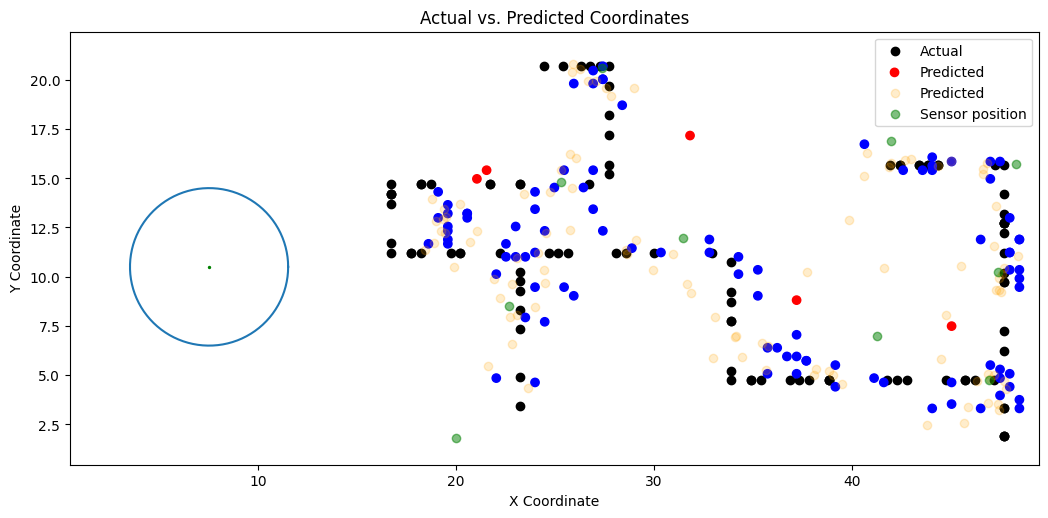

0.9605911330049262
Array saved to ./RMSE_b_machine_2.txt_2.txt


In [20]:
pred2 = model_B.predict(data_B[:,:-2])
pred_2val = np.array([])
true_label = np.array([])
sensor_np = np.array(np.array(final_sensor_positions).reshape(-1,2))


actual_coords = data_B[:,-2:]
# Inverse Transform Predicted and Actual Coordinates
predicted_coords = np.array(pred2)
actual_coords = np.array(actual_coords)
board_coords = ad

predicted_x_inv = sc_x.inverse_transform(predicted_coords[:, 0].reshape(-1, 1))
predicted_y_inv = sc_y.inverse_transform(predicted_coords[:, 1].reshape(-1, 1))
print(predicted_x_inv.shape)

actual_x_inv = sc_x.inverse_transform(actual_coords[:, 0].reshape(-1, 1))
actual_y_inv = sc_y.inverse_transform(actual_coords[:, 1].reshape(-1, 1))

board_x_inv = sc_x.inverse_transform(board_coords[:, 0].reshape(-1, 1))
board_y_inv = sc_y.inverse_transform(board_coords[:, 1].reshape(-1, 1))

x_center = 7.5
y_center = 10.5
radius = 4
decision = np.array([])
decision2 = np.array([])
for i in range(len(predicted_coords)):
    decision = np.append(decision, 0 if distance((predicted_x_inv[i],predicted_y_inv[i]), (actual_x_inv[i],actual_y_inv[i])) < radius else 1)
for i in range(len(board_y_inv)):
    decision2 = np.append(decision2, 0 if distance((board_x_inv[i],board_y_inv[i]), (actual_x_inv[i+3],actual_y_inv[i+3])) < radius else 1)
print(decision)

theta = np.linspace(0, 2 * np.pi, 100)
x = x_center + radius * np.cos(theta)
y = y_center + radius * np.sin(theta)

#actual_sensor_x = sc_x.inverse_transform(sensor_np[:, 0].reshape(-1, 1))
#actual_sensor_y = sc_y.inverse_transform(sensor_np[:, 1].reshape(-1, 1))
actual_sensor_x = sensor_np[:, 0].reshape(-1, 1)
actual_sensor_y = sensor_np[:, 1].reshape(-1, 1)
n = 100
# Plot Predictions vs. Actual Coordinates
plt.figure(figsize=(12.5, 5.625))
plt.axis([0.4675112982323418, 49.46751129823234, 0.44997892328107925, 22.44997892328108])
plt.scatter(actual_x_inv[:n], actual_y_inv[:n], c='black', label='Actual', alpha=1)
plt.scatter(board_x_inv[:n], board_y_inv[:n], c=decision2[:n], cmap='bwr', label='Predicted', alpha=1)
plt.scatter(predicted_x_inv[:n], predicted_y_inv[:n], c='orange', label='Predicted', alpha=0.2)
plt.scatter(actual_sensor_x,actual_sensor_y, c='green', label='Sensor position', alpha = 0.5)

plt.plot(x, y)
plt.scatter(x_center, y_center, color='green', s=2) # Mark the center
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs. Predicted Coordinates')
plt.legend()
plt.show()
print(1-decision2.sum()/len(decision2))
distances = np.array([])
for i in range(len(predicted_x_inv)):
    distances = np.append(distances, distance((predicted_x_inv[i],predicted_y_inv[i]), (actual_x_inv[i],actual_y_inv[i])))
save_array_numpy(distances,"RMSE_b_machine_2.txt")

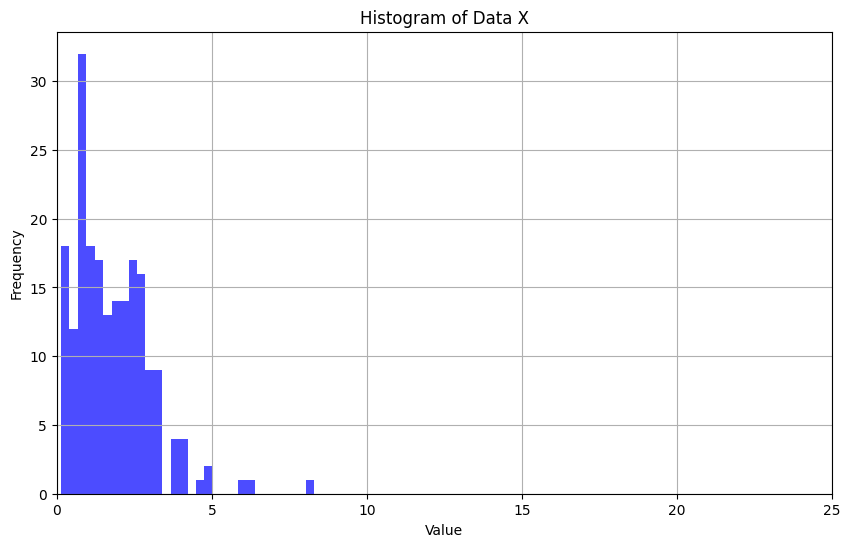

Array saved to ./RMSE_b_machine_2.txt_1.txt


In [19]:
distances = np.array([])
for i in range(len(board_x_inv)):
    distances = np.append(distances, distance((board_x_inv[i],board_y_inv[i]), (actual_x_inv[i+3],actual_y_inv[i+3])))
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=30, alpha=0.7, color='blue')
plt.xlim(0, 25)
plt.title('Histogram of Data X')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
save_array_numpy(distances,"RMSE_b_machine_2.txt")